## Image Reconstruction

Choose any image you like. Use **Random Fourier Features (RFF)** and **Linear Regression** to learn the mapping from the image coordinates (**X, Y**) to the pixel colors (**R, G, B**).  
Here, (X, Y) represents the coordinates of the pixels, and (R, G, B) represents the color values at those coordinates.

### Steps

1. **Load Image**: Select any image of your choice.
2. **Random Fourier Features (RFF)**: Implement RFF to map pixel coordinates to color values.
3. **Linear Regression**: Use linear regression to learn the mapping.
4. **Display Results**: Show both the original and reconstructed images.
5. **Metrics**: Calculate the **Root Mean Squared Error (MSE)** and **Peak Signal-to-Noise Ratio (PSNR)** between the original and reconstructed images.

---

###  Key Variables

- **X, Y**: Pixel coordinates  
- **R, G, B**: Pixel color values


### Importing necessary libraries

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:

    from einops import rearrange

print("Import Completed")

Device:  cuda
Import Completed


In [12]:
# Watermark code to print library versions
import watermark
%load_ext watermark
%watermark -n -v -m -g -b -t -p torch,torchvision,numpy,pandas,matplotlib,einops,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.30.0

torch      : 2.6.0+cu118
torchvision: 0.21.0+cu118
numpy      : 2.2.2
pandas     : 2.2.3
matplotlib : 3.9.3
einops     : 0.8.1

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 16
Architecture: 64bit

Git hash: 

Git branch: 



In [13]:
# Set the random seed for reproducibility
torch.manual_seed(42)

In [14]:
import os

# Define the directory path
directory_path = '../assets/images/'

# Check if the directory exists, and create it if it does not
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Check if the file exists
if os.path.exists(os.path.join(directory_path, 'iitgn.jpeg')):
    print('iitgn.jpeg exists')
else:
    # Download the file if it does not exist
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O ../assets/images/dog.jpg
    !wget https://campus.iitgn.ac.in/gallery/academic_area/data1/images/central_samvad_in_the_academic_spine.jpg -O ../assets/images/iitgn.jpg

    !wget https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg -O ../assets/images/iitgn.jpg
print("Download Successful!")

--2025-06-22 10:27:18--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.158.61.125, 108.158.61.10, 108.158.61.61, ...
Connecting to segment-anything.com (segment-anything.com)|108.158.61.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: '../assets/images/dog.jpg'

     0K .......... .......... .......... .......... .......... 23% 6.35M 0s
    50K .......... .......... .......... .......... .......... 46% 7.63M 0s
   100K .......... .......... .......... .......... .......... 69% 13.5M 0s
   150K .......... .......... .......... .......... .......... 92% 10.5M 0s
   200K .......... ......                                     100% 30.3M=0.02s

2025-06-22 10:27:19 (9.25 MB/s) - '../assets/images/dog.jpg' saved [221810/221810]

--2025-06-22 10:27:19--  https://campus.iitgn.ac.in/gallery/academic_area/data1/images/central_

Download Successful!


--2025-06-22 10:27:20--  https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg
Resolving news.iitgn.ac.in (news.iitgn.ac.in)... 4.213.52.179
Connecting to news.iitgn.ac.in (news.iitgn.ac.in)|4.213.52.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238762 (233K) [image/jpeg]
Saving to: '../assets/images/iitgn.jpg'

     0K .......... .......... .......... .......... .......... 21%  948K 0s
    50K .......... .......... .......... .......... .......... 42% 1.69M 0s
   100K .......... .......... .......... .......... .......... 64% 2.01M 0s
   150K .......... .......... .......... .......... .......... 85% 5.65M 0s
   200K .......... .......... .......... ...                  100% 11.4M=0.1s

2025-06-22 10:27:21 (1.94 MB/s) - '../assets/images/iitgn.jpg' saved [238762/238762]



In [15]:
# Read in a image from torchvision
img = torchvision.io.read_image("../assets/images/iitgn.jpg")
print(img.shape)

torch.Size([3, 600, 900])


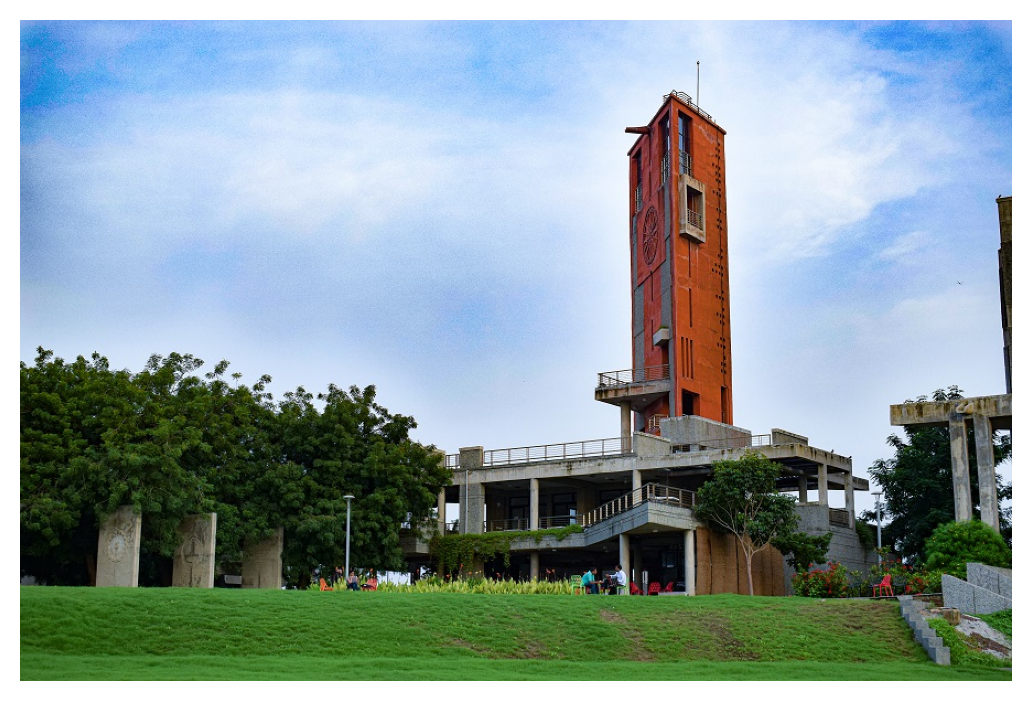

In [16]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.axis('off')
plt.show()

In [17]:
scaler = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaled_img = scaler.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img).float().to(device)
print(scaled_img.shape)
print(scaled_img)

torch.Size([3, 600, 900])
tensor([[[0.5412, 0.5333, 0.4863,  ..., 0.5451, 0.5608, 0.5412],
         [0.5059, 0.5373, 0.5059,  ..., 0.5647, 0.5451, 0.5451],
         [0.5412, 0.5333, 0.5098,  ..., 0.5647, 0.5216, 0.5373],
         ...,
         [0.2627, 0.2941, 0.2549,  ..., 0.2314, 0.2157, 0.1843],
         [0.1647, 0.1647, 0.1882,  ..., 0.2314, 0.2196, 0.2078],
         [0.2039, 0.2275, 0.2588,  ..., 0.2157, 0.2039, 0.2157]],

        [[0.6902, 0.6902, 0.6667,  ..., 0.6667, 0.6824, 0.6627],
         [0.6549, 0.6941, 0.6667,  ..., 0.6863, 0.6667, 0.6667],
         [0.6784, 0.6706, 0.6471,  ..., 0.6863, 0.6431, 0.6588],
         ...,
         [0.4667, 0.4980, 0.4588,  ..., 0.4157, 0.4000, 0.3686],
         [0.3647, 0.3647, 0.3882,  ..., 0.4157, 0.4039, 0.3922],
         [0.4039, 0.4275, 0.4588,  ..., 0.4000, 0.3882, 0.4000]],

        [[0.9333, 0.9294, 0.9020,  ..., 0.9294, 0.9451, 0.9255],
         [0.8980, 0.9333, 0.9098,  ..., 0.9490, 0.9294, 0.9294],
         [0.9294, 0.9216, 0.9059

torch.Size([3, 200, 200])


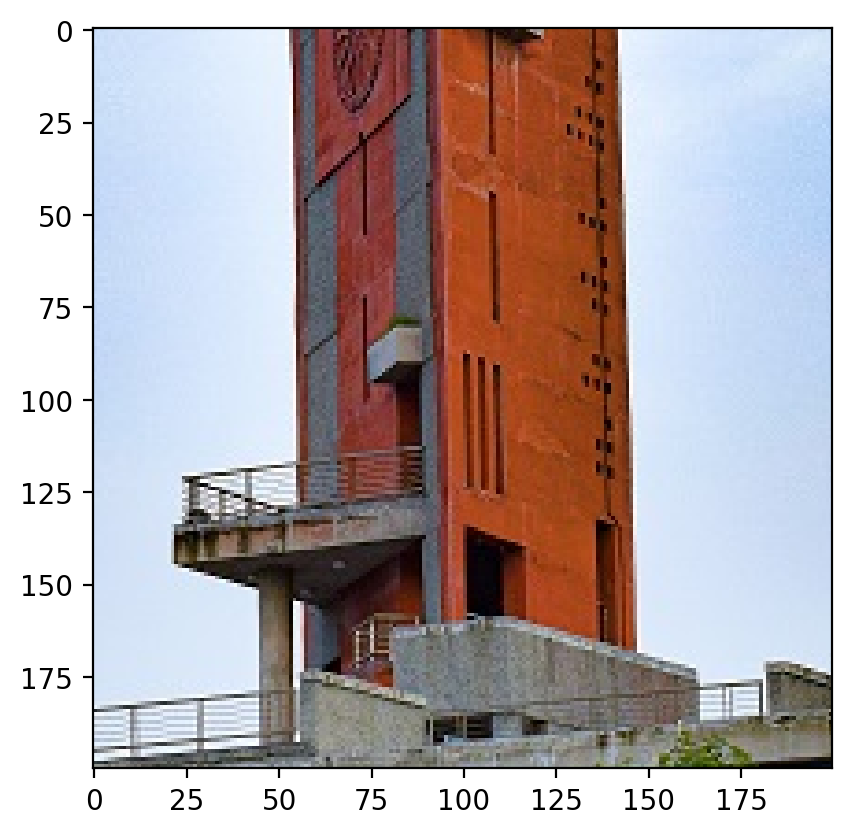

In [18]:
crop_og = torchvision.transforms.functional.crop(scaled_img.cpu(),200, 500, 200, 200)
print(crop_og.shape)

plt.imshow(rearrange(crop_og, 'c h w -> h w c').cpu().numpy())

torch.Size([3, 100, 100])


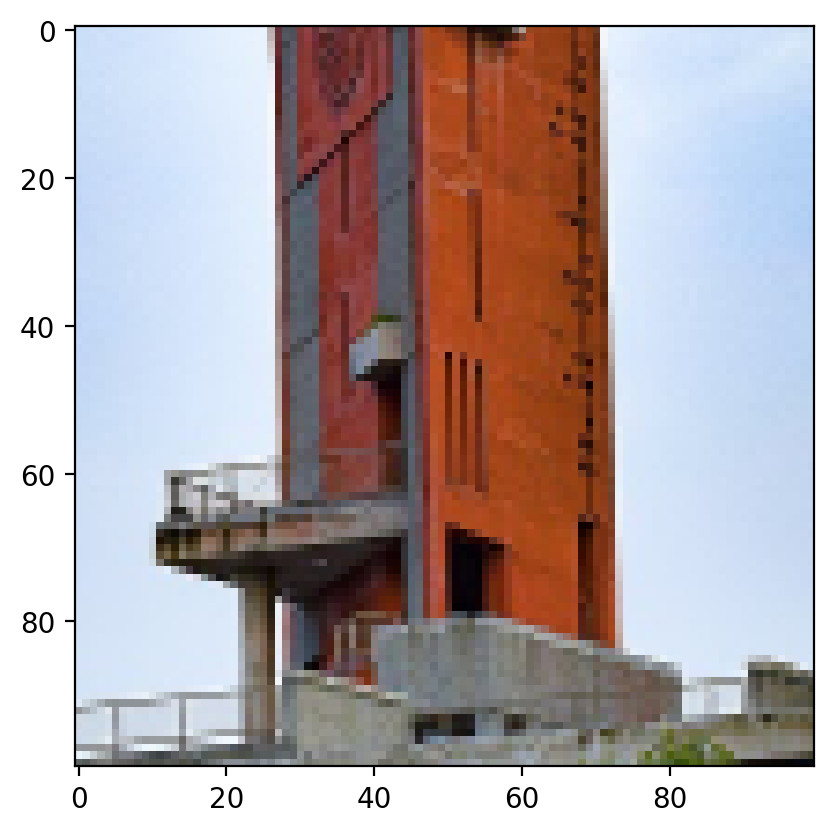

In [19]:
crop = torch.tensor(rearrange(cv2.resize(rearrange(crop_og.numpy(), 'c h w -> h w c'), (100, 100)), 'h w c -> c h w'))
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


### Create a Coordinate Map

In [20]:
def create_coordinate_map(img, scale = 1):
   

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

### Function to Calculate RMSE and PSNR

In [21]:
def calculate_metrics(original_image, reconstructed_image, max_pixel_value=1.0):
    """
    Calculate RMSE and PSNR between the original and reconstructed images.

    Parameters:
    - original_image (torch.Tensor): The original image tensor.
    - reconstructed_image (torch.Tensor): The reconstructed image tensor.
    - max_pixel_value (float): The maximum pixel value for PSNR calculation.

    Returns:
    - rmse (float): The Root Mean Squared Error.
    - psnr (float): The Peak Signal-to-Noise Ratio.
    """
    # Ensure the images are on the same device
    original_image = original_image.to(reconstructed_image.device)

    # Calculate RMSE
    mse = torch.mean((original_image - reconstructed_image) ** 2)
    rmse = torch.sqrt(mse).item()

    # Calculate PSNR
    if mse == 0:  # MSE is zero means images are identical
        psnr = float('inf')
    else:
        psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse)).item()

    return rmse, psnr

### Defining Linear Model

In [22]:

class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        # Define a linear transformation
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [31]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()



In [ ]:
def train_with_rff(img, num_features, sigma, learning_rate, epochs):
    img = img.to(device)

   
    X, Y = create_coordinate_map(img, scale=1)
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu()), dtype=torch.float32).to(device)

 
    rff_sampler = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    rff_X = rff_sampler.fit_transform(scaled_X.cpu().numpy())
    rff_X_tensor = torch.tensor(rff_X, dtype=torch.float32).to(device)

 
    net = LinearModel(input_dim=rff_X.shape[1], output_dim=Y.shape[1]).to(device)
    train(net, learning_rate, rff_X_tensor, Y, epochs, verbose=True)

    # Step 4: Predict output and reconstruct image
    with torch.no_grad():
        reconstructed_Y = net(rff_X_tensor).cpu().numpy()
        h, w = img.shape[1], img.shape[2]
        reconstructed_img = reconstructed_Y.reshape(h, w, img.shape[0])  
        reconstructed_img = rearrange(reconstructed_img, 'h w c -> c h w')  

    X_scaled, Y_scaled = create_coordinate_map(img, scale=2)
    rff_X_scaled = rff_sampler.transform(scaler.transform(X_scaled.cpu().numpy()))
    rff_X_scaled_tensor = torch.tensor(rff_X_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        reconstructed_Y_scaled = net(rff_X_scaled_tensor).cpu().numpy()
        h, w = img.shape[1] * 2, img.shape[2] * 2
        reconstructed_img_scaled = reconstructed_Y_scaled.reshape(h, w, img.shape[0])  
        reconstructed_img_scaled = rearrange(reconstructed_img_scaled, 'h w c -> c h w')
    
    return reconstructed_img, reconstructed_img_scaled


def plot_images(original, reconstructed, reconstructed_scaled):
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.imshow(rearrange(original, 'c h w -> h w c').cpu().numpy())
    ax0.set_title('Original Image')
    ax0.axis('off')

    ax1 = plt.subplot(gs[1])
    ax1.imshow(rearrange(reconstructed, 'c h w -> h w c').cpu().numpy())
    ax1.set_title('Reconstructed Image')
    ax1.axis('off')

    ax2 = plt.subplot(gs[2])
    ax2.imshow(rearrange(reconstructed_scaled, 'c h w -> h w c').cpu().numpy())
    ax2.set_title('Reconstructed Scaled Image')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

reconstructed_img, reconstructed_img_scaled = train_with_rff(crop, num_features=50000, sigma=0.03, learning_rate=0.0008, epochs=2000)
plot_images(crop, reconstructed_img, reconstructed_img_scaled)



NameError: name 'reconstructed_img' is not defined